In [ ]:
!pip install statsmodels

In [5]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


In [6]:
all_data_df = pd.read_csv("data/raw/data.csv")
ss = pd.read_csv('data/raw/SampleSubmission.csv')

In [7]:
len(ss)

6014

In [8]:
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,0,10
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10


In [9]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame (optional)
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1


In [10]:
# These are the devices that are not in the test SampleSubmission

devices_to_drop = ["consumer_device_3","consumer_device_5","consumer_device_11", "consumer_device_14",
                   "consumer_device_15", "consumer_device_17", "consumer_device_24",
                   "consumer_device_25","consumer_device_27","consumer_device_33","consumer_device_4","consumer_device_9"]

In [11]:
# Filter the DataFrame to include only rows where 'consumer_device' is in the 'devices_to_drop' list.
filtered_df = all_data_df[all_data_df['consumer_device'].isin(devices_to_drop)]

# Now 'filtered_df' contains only the rows you specified.  You can further process or save this DataFrame.
filtered_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user
327816,2023-10-01 14:35:00,169.26,3.50,0.73,0.036038,consumer_device_11_data_user_1,NaN,NaN,0,11,consumer_device_11,1
327817,2023-10-01 14:40:00,169.20,3.15,0.76,0.033755,consumer_device_11_data_user_1,NaN,NaN,0,11,consumer_device_11,1
327818,2023-10-01 14:45:00,168.38,2.58,0.73,0.026427,consumer_device_11_data_user_1,NaN,NaN,0,11,consumer_device_11,1
327819,2023-10-01 14:50:00,168.87,2.52,0.76,0.026952,consumer_device_11_data_user_1,NaN,NaN,0,11,consumer_device_11,1
327820,2023-10-01 14:55:00,168.30,2.47,0.75,0.025981,consumer_device_11_data_user_1,NaN,NaN,0,11,consumer_device_11,1


In [12]:
# for all_data["Source"] aggregate by sum on day

import pandas as pd
# Assuming 'all_data_df' is already defined as in your previous code.
# Convert 'Datetime' column to datetime objects if it's not already
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

# Extract the date part
all_data_df['Date'] = all_data_df['date_time'].dt.date

# Group by 'Source' and 'Date', then sum the 'Load' for each group
aggregated_data = all_data_df.groupby(['Source', 'Date'])['kwh'].sum().reset_index()

# Display the aggregated data
aggregated_data.head()


,Source,Date,kwh
0,consumer_device_10_data_user_1,2024-07-22,0.024330
1,consumer_device_10_data_user_1,2024-07-23,0.103560
2,consumer_device_10_data_user_1,2024-07-24,0.137543
3,consumer_device_10_data_user_1,2024-07-25,0.121011
4,consumer_device_10_data_user_1,2024-07-26,0.000000


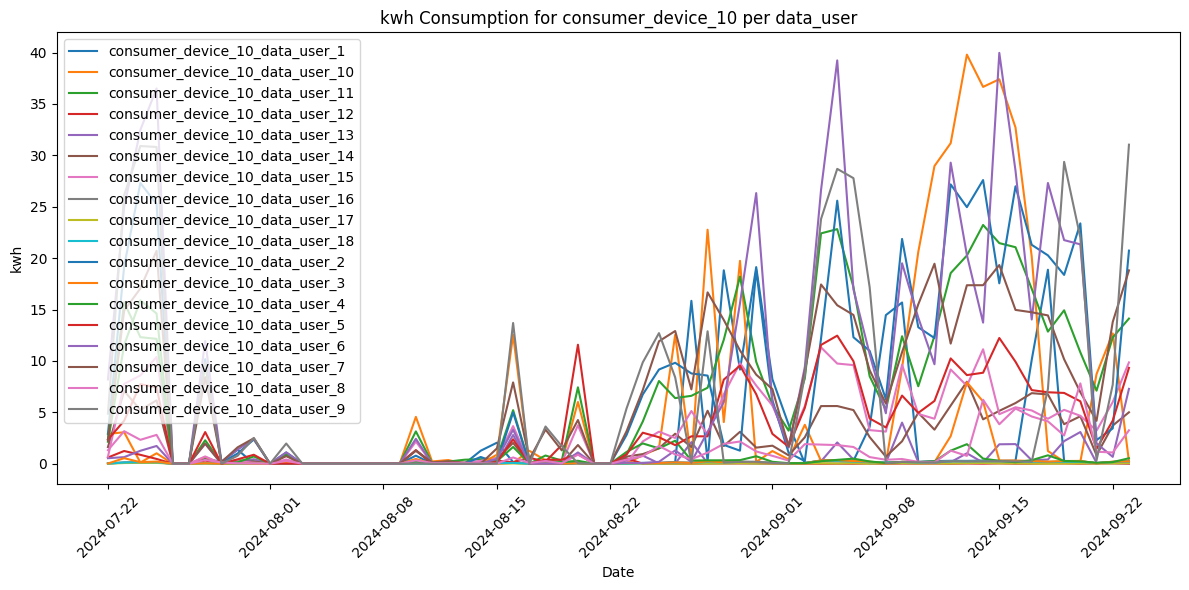

In [13]:
# Filter data for consumer_device_10
consumer_10_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_10')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Find the minimum and maximum date_time values
min_date = aggregated_data['Date'].min()
max_date = aggregated_data['Date'].max()

print(f"Minimum date_time: {min_date}")
print(f"Maximum date_time: {max_date}")

Minimum date_time: 2023-06-03
Maximum date_time: 2024-09-23


In [17]:
print(aggregated_data.shape)

(136409, 3)


In [15]:
# Fill missing date values with 0 kwh

# Create a date range
date_rng = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the complete data
complete_data = pd.DataFrame()

# Iterate through each unique 'Source'
for source in aggregated_data['Source'].unique():
    # Extract data for the current 'Source'
    source_data = aggregated_data[aggregated_data['Source'] == source].copy()

    # Convert the source data Date to match the type of date_rng
    source_data['Date'] = pd.to_datetime(source_data['Date'])

    # Create a complete date range for the current 'Source'
    source_date_rng = pd.DataFrame({'Date': date_rng})
    source_date_rng['Source'] = source

    # Merge with the existing data, filling missing 'kwh' values with 0
    source_data = pd.merge(source_date_rng, source_data, on=['Date', 'Source'], how='left')
    source_data['kwh'] = source_data['kwh'].fillna(0)

    # Append to the complete data
    complete_data = pd.concat([complete_data, source_data], ignore_index=True)

In [16]:
print(complete_data.shape)
complete_data.head()

(280215, 3)


,Date,Source,kwh
0,2023-06-03,consumer_device_10_data_user_1,0.0
1,2023-06-04,consumer_device_10_data_user_1,0.0
2,2023-06-05,consumer_device_10_data_user_1,0.0
3,2023-06-06,consumer_device_10_data_user_1,0.0
4,2023-06-07,consumer_device_10_data_user_1,0.0


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Function to process and forecast per unique consumer_device_x and data_user_y
def forecast_arima(all_data, forecast_horizon=30, output_template=None):
    # Convert Date column to datetime format
    all_data['Date'] = pd.to_datetime(all_data['Date'])

    # Extract consumer_device_x and data_user_y
    all_data[['consumer_device', 'data_user']] = all_data['Source'].str.extract(r'consumer_device_(\d+)_data_user_(\d+)')

    # Ensure data is sorted by consumer_device, data_user, and Date
    all_data = all_data.sort_values(by=['consumer_device', 'data_user', 'Date'])

    # Store forecasts
    forecast_results = []

    # Process each unique consumer_device_x and data_user_y combination
    for (consumer_device, data_user), group in all_data.groupby(["consumer_device", "data_user"]):
        # Set Date as index
        group = group.set_index("Date")

        # Ensure data is in the correct format
        group = group.asfreq('D').fillna(method='ffill')  # Fill missing dates with last known value

        # Fit ARIMA model
        try:
            model = ARIMA(group["kwh"], order=(5, 1, 0))  # ARIMA(5,1,0) as a baseline
            fitted_model = model.fit()

            # Forecast for the next forecast_horizon days
            forecast_dates = pd.date_range(start=group.index[-1] + pd.Timedelta(days=1),
                                           periods=forecast_horizon, freq='D')
            forecast_values = fitted_model.forecast(steps=forecast_horizon)

            # Store results in required format
            forecast_df = pd.DataFrame({
                "ID": [f"{date.strftime('%Y-%m-%d')}_consumer_device_{consumer_device}_data_user_{data_user}"
                        for date in forecast_dates],
                "kwh": forecast_values
            })

            forecast_results.append(forecast_df)

        except Exception as e:
            print(f"Error processing {consumer_device}_{data_user}: {e}")

    # Combine all forecasts into a single DataFrame
    forecast_df = pd.concat(forecast_results, ignore_index=True)

    # If an output template is provided, align the output format
    if output_template is not None:
        output_template = output_template.drop(columns=['kwh'], errors='ignore')
        final_output = output_template.merge(forecast_df, on='ID', how='left').fillna(0)
    else:
        final_output = forecast_df

    return final_output, forecast_df


In [ ]:
forecast, orig_forecast = forecast_arima(all_data=complete_data, forecast_horizon=30, output_template=ss)

In [ ]:
forecast.head()

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.157003
1,2024-09-25_consumer_device_12_data_user_1,0.157044
2,2024-09-26_consumer_device_12_data_user_1,0.206450
3,2024-09-27_consumer_device_12_data_user_1,0.188694
4,2024-09-28_consumer_device_12_data_user_1,0.166484


In [ ]:
# prompt: does forecast["kwh"] contain nans if so replace with 0

# Check for NaN values in the 'kwh' column and replace them with 0
forecast["kwh"] = forecast["kwh"].fillna(0)


In [ ]:
len(complete_data), len(forecast), len(ss)

(114958, 6014, 6014)

In [ ]:
forecast.to_csv("forecast.csv", index = False)

In [ ]:
# prompt: list the difference in the ID between forecast and ss

# Assuming 'forecast' and 'ss' DataFrames are already defined as in your provided code.

# Convert 'ID' columns to sets for efficient comparison
forecast_ids = set(forecast['ID'])
ss_ids = set(ss['ID'])

# Find IDs present in forecast but not in ss
forecast_only_ids = forecast_ids - ss_ids

# Find IDs present in ss but not in forecast
ss_only_ids = ss_ids - forecast_ids

# Print the IDs that are in forecast but not in ss
print("IDs in 'forecast' but not in 'ss':")
print(forecast_only_ids)


# Print the IDs that are in ss but not in forecast
print("\nIDs in 'ss' but not in 'forecast':")
print(ss_only_ids)

# Print the number of IDs that differ
print(f"\nNumber of IDs that differ: {len(forecast_only_ids) + len(ss_only_ids)}")


IDs in 'forecast' but not in 'ss':
set()

IDs in 'ss' but not in 'forecast':
set()

Number of IDs that differ: 0


In [ ]:
# prompt: compute RMSE score between forecast and ss

import pandas as pd
from sklearn.metrics import mean_squared_error
import math

# Assuming 'forecast' and 'ss' are DataFrames with a common 'ID' column and a 'kwh' column
# containing the forecast and actual values respectively.

# Merge the forecast and ss DataFrames on the 'ID' column
merged_df = pd.merge(forecast, ss, on='ID', how='left', suffixes=('_forecast', '_actual'))

# Calculate the RMSE
rmse = math.sqrt(mean_squared_error(merged_df['kwh_actual'], merged_df['kwh_forecast']))

print(f"RMSE: {rmse}")


RMSE: 9.312750604651274
